## In this notebook, we'll be working with MNIST, a very common ML dataset of 70K small images of digits handwritten by high schools students

In [14]:
# Download the dataset using scikit-learn

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [15]:
# Let's look at arrays


X, y = mnist["data"], mnist["target"]
y.shape

(70000,)

In [16]:
X.shape

(70000, 784)

There are 70K images, and each image has 784 features --this is b/c 28 x 28 pixels.
Each feature simply represetns one pixel's intensity from 0 (white) to 255 (black)

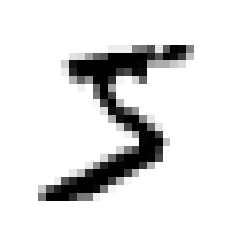

In [17]:
# Let's look at one digit from the dataset:

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()



 Looks like a 5, and that is indeed what the label tells us

In [18]:
y[0]

'5'

Note: the label is a string --we prefer int so let's cast y to an int:

In [19]:
import numpy as np

y = y.astype(np.uint8)

The MNIST dataset is already split inito a training set (first 60K  images) and a test set (last 10K images)

In [20]:
# Split the data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


## Training a binary classifier
Let's try to solve a smaller problem: only try to identify one digit -- the number 5.  We will use a binary classifer capable of distinguishing btw just two classes 5 or not 5. 



In [21]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test == 5)

let's pick a classifier and train it. A good classifer to start is Stochaistic Gradient Descent (SGD). Advantage: able to handle V large datasets efficiently. Deals / training instances independently --one at a time. 


In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42) 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SGDClassifier relies on randomness during training, hence name "stochaastic".

In [23]:
# Now you can detect images of the number 5:

sgd_clf.predict([some_digit])

array([ True])

Now we are going to assess the performance of a classifier. It is a bit more complex than doing so for a linear regression. 

In [24]:
# Implementation fo a Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0. 6495

/Users/caleboh/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.




In [25]:
# Let's use the cross_val_score() function to evaluate using K-fold cross-validation:

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

Woah! The accuracy above 95% & 93 both seem really high! But don't too excited. The dummy clasifier that only classified every image as "not-5" class has an accuracy of 90% (see below). Hence, accuracy of classification is not a good test of performance

In [26]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [27]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

A better alt for evaluation is a confusion matrix. General idea: to count times that instances of class A are wrongly classified as class B (i.e., confuses one with the other) --confusion matrix uses false positive type grid to assess performance.

In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [29]:
# Now just pass the confusion matrix targer classes (y_train_5) and the predicted classes (y_train_pred):

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

In [30]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]])

precision = relevant instance among the retrieved 
recall = relevant instance retrieved among all relevant instances avaliable. 

There is a trade-off betwen precision and recall.
Let's calculatte precision & Recall --two types of classifier metrics

In [31]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096/ (4096 + 1522)


0.8370879772350012

In [32]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

Dang, so we're only recalling 65% of the 5's

It's often helpful to combine the precision and recall metrics into a single metric called F1 score. 
F1 isthe harmonic mean of precision and recall --harmonic gives more weight to lower values than regular mean.

compute the F score below:

In [33]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 favors classifiers w/ similar precision and recall. 

SKlearn allows you to indirectly set the threshold

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)

# The SGDClassifier uses the threshold equal to 0, so the previous code returns the same results as predict() method


In [35]:
# Let's raise the threshold

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [36]:
# This output comfirms that raising the threshold decreases recall
# Now let's figure out how you know which threshold to use. 

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, 
                            method = "decision_function")


In [37]:
# Now w/ these scores, you can compute precision and recalll for all possible thresholds"

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [38]:
# YOu can plot precision and recall as functions of the threshold value using Matplotlib:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    # highlight the threshold, add legend, axis label and grid.
    
plot_precision_recall_vs_threshold(precision, recalls, thresholds)

plt.show()

NameError: name 'precision' is not defined

In [ ]:
# Setting the precision to 90

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

# To make predictions on the training set for now

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
# Let's check the predictions
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

Remember that even though you can set a high precision, there is a cost incurred by the recall!

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Now we can plot the FPR by the TPR using matplotlib.

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k==') # dashed diagnol
    # add labels and the grid
    
plot_roc_curve(fpr, tpr)
plt.show()

The higher the recall, the higher the false positive rate --this is the trade-off. 

One way to compare classifiers is to measure the area under the curve (AUC). A per‐ fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

--note: there should be a straight dotted-line w/ positive slope that represents a random classifier (should turn out a 0.5 area below the curve).

In [ ]:
# Let's calc the AUC -- area under the curve -- 
# Closer to 1 is a better classifier
# Closer to 0.5 is worse classifier

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


As a rule of thumb, you should prefer the PR (precision/recall) curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.

Here we are going to train a random forest classifier and compare the ROC curve to that of SGD classifier. 

note: randomforestclassifier doesn't have the deicison_fucntion(), instead it has predict_prob()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                   method = "predict_proba")

In [ ]:
# But for ROC curves we need scores, not probs, a simple solution is to use positive class's prob as the scores

y_scores_forest = y_probas_forest[:, 1] # Score = prob of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)



In [ ]:
# let's see the plot and compare the two:

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

# Dotted-line is the SGD and the solid is random forest.

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

In [ ]:
precision_score(y_train_5, y_scores_forest)

# Multiclass Classification

Where binary classifiers only distninguish 2 classes, we will be learning multi-class classifers that have multple categories/classes (e.g. tryin to figure out if image is green, blue, or yellow) --this necessary requieres us to use meta approaches that uses higher order binary classification. 
### mutliclass classifier: 
1. random forest
2. naive bayes 

### binary classifier: 
1. support vector machine
2. linear classifier

## Strategies for multiclass
1. one-vs-all (OvA)
Here, you either classify the image as belonging to the specific class (yellow), or not (anything else --blue or green). Hence, you make a class for each of the 3 classes. 

2. one-vs-one (OvO)
You create classes based on binary pairing. (blue vs green, green vs yellow ect).

If there are N classes, you need N x (N - 1) / 2 classifiers. 

When wanting to classify the image, you need to run thet image thru all the 45 classifiers and see which one wins the most duels. The main advantage is each classifer only needs to be trained on the part of the training set for the two classes that it must distinguish. 

For most Bianry classifiers, OvO is preferred --even though you will inevitably have more datasets to run the algorithms on. 


Sklearn detects when you try to use binary classification algo for a multi-class task -> it automatically rusn OvA:

Let's try this with the sgd classifier:

In [45]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [46]:
# To look under the hood to confirm that OvO was used, 
# --you can do the following and see that you get 10 scores

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
np.argmax(some_digit_scores)
sgd_clf.classes_
sgd_clf.classes_[5]

5

If you want to force sklearn to use OVO or OVA instead of default, you can do the following 

In [48]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

In [49]:
# Training a random forest classifier is also easy!

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

# Note that you don't have to run OvA or OvO since random forest 
# Can directly classify instances into multiple classes. 


NameError: name 'forest_clf' is not defined

In [ ]:
# You can call predict_proba() to get a list of prob that the classifer 
# Assigned to each instance for each class

forest_clf.predict_proba([some_digit])

From the results, you can that the 0.9 at the 5th index indicates that our model predicts with 90% accuracy that the image represents a 5. 

As usual, we want to cross validate results. Let's use cross_valu_score() to evaluate the accuracy of SGDClassifer 

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoreing = "accuracy")

TypeError: cross_val_score() got an unexpected keyword argument 'scoreing'

It get's a 84% on all test folds. If you use a radom classifer, you would get 10% accuracy --so not a bad score. You could still do better tho. e.g. simple scaling of the inputs increases accuracy (ref to ch2). 

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")


array([0.8983, 0.891 , 0.9018])

## Error Analysis 

Scaffolding for ML project workflow:

1. Exploration of the data
2. Trying out multiple models
3. Short listing the best models 
4. Fine-tuning hyperparamters (using GridSearchCV)
5. Automating as much as possible
6. Now that you have promising model, find ways to improve by analyzing types of errors it makes. 

In [52]:
# First let's look at a confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

NameError: name 'coonf_mx' is not defined

<function matplotlib.pyplot.show(*args, **kw)>

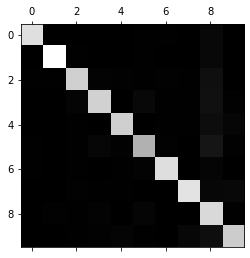

In [53]:
# that is pretty cryptic, so lets look at a better image representation

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show

confusion matrix looks good since most images on are on the main diagnol which means that they were classified correctly. 5s lookk slightly darker than the other digits --means that either there were fewer images of 5s in dataset or the classifer did not perform as well on the 5s as on other digits. However, you can verify whether both were the case. 

In [57]:
# First we need to divide each value in the confusion matrix by number 
# of images in the corresponding class, so you can compare error rates 
# instead of absolute value of the number of errors. 

row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

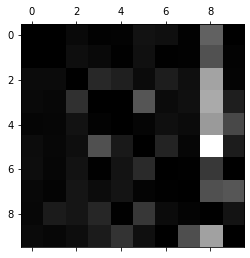

In [59]:
# Okay now let's fill the diagnols w/ zeros (0s mean true) to keep only errors

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Alright, now we can clearly see the errors the model makes. Rows represent actual classes. Columns represented the numbers that were predicted by the model. 

Hence, the white being errors, you see that 8 are the most poorly predicted by our model. You also see that 5s/3s are mixed up both ways since there are white spots in the columns and the rows. 

Analyzing individual errors could be a good way to gain insights on what your classifier is doing wrong and why it is failing --but the trade-off is that this is time-consuming. Let's do it anyways.


NameError: name 'matplotlib' is not defined

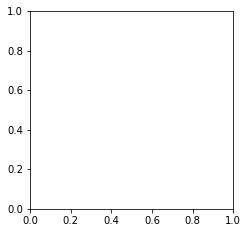

In [63]:
# Let's plot exampels of 3s and 5s

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()



bottom left and top right blocks are digits that the classifier gets wrong. You learn that 3/5 errors is a consequence of the small line that joins the top line to the bottom arc. Hence the classifier is sensitive to image shifting and rotating. So one way to reduce error is to preprocess the timages to ensure they are well centered and not too rotated. 

## Multi-labeled Classification

What if you want a classification systemt hta outputs multiple binary tags (e.g. you want algo to identify all the people within a picture --either they are the person, or not)

In the code below, we create an array containing two target labels for each digit image: first indicates whether or not digit is larger than (7,8, or 9) and the second tells whetehr or not it is odd. 

Next line creates a K-neighbors-classifier instance, and we train it using the mutlple targets array.

In [65]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [66]:
# Now you can make a predicition and notice it outputs 2 labels:

knn_clf.predict([some_digit])


array([[False,  True]])

And that is true, the 5 is indeed not large(False) and odd(True)!

There are ways to evaluate the performance (see book for more details)

## Multioupt classification

This is the last classification task we look at. Put simly, it is a geranlization of the previous multi-class calssification --hence each label can have multiple values. 

e.g. Here we make a function that takes in a noisy digit image, and outputs a clean digit number. 

The classifier's output is multilabeled (one label per pixel) and each label has multple values (pixel rangin from 0 to 255). This is therefore a multioutput classification system. 

In [69]:
# Create training and test sets, taking MNIST imgaes + 
# --adding noise to their pixel intensities using randint() function. 

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_train_mod = X_test

In [70]:
# Now, let's kuse the classifer to make the image clean

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

ValueError: Found input variables with inconsistent numbers of samples: [60000, 10000]

## Exersizes 
see page 110